In [1]:
import os
import cv2
import gdcm
import pydicom
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt

from dicom2stl.examples import gui
from dicom2stl.utils import vtkutils
from dicom2stl.examples.myshow import myshow, myshow3d

from pydicom import dcmread
from pydicom.data import get_testdata_file
from pydicom.uid import ExplicitVRLittleEndian

from skimage import feature, filters
from skimage.filters import roberts, sobel, scharr, prewitt

from scipy import ndimage
from PIL import Image, ImageFilter

import itkwidgets

%load_ext autoreload
%autoreload 1

In [2]:
%matplotlib notebook

## Original Images

In [3]:
path = "pos_twist_05iso_37"

In [22]:
reader = sitk.ImageSeriesReader()
dicom_names = reader.GetGDCMSeriesFileNames(path)
reader.SetFileNames(dicom_names)
original_image = reader.Execute()

size = image.GetSize()
size

(192, 512, 120)

<IPython.core.display.Javascript object>


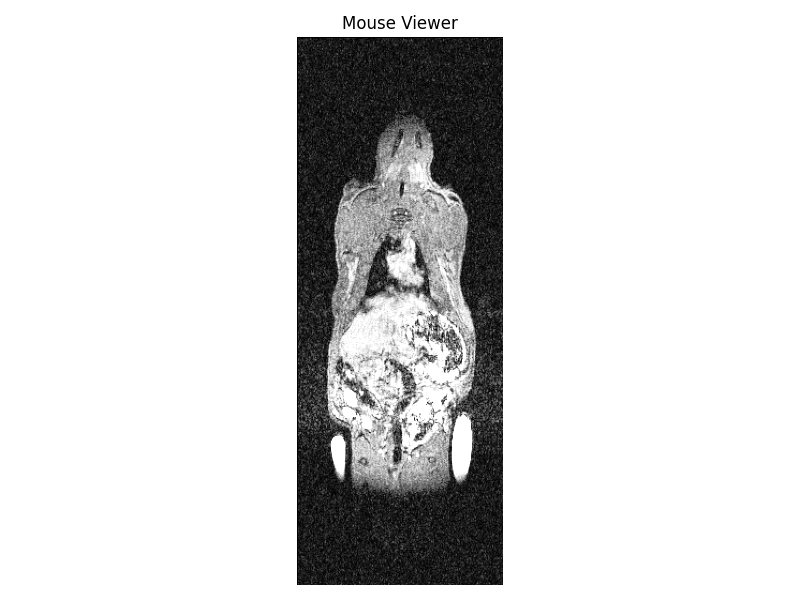

In [23]:
gui.MultiImageDisplay(image_list=[original_image], title_list=['Mouse Viewer'], figure_size=(8,6))

## Filter Images

In [11]:
#!mkdir filter_images

In [12]:
def save_dicom_file(original_file, new_array, file_path):

    original_file.file_meta.TransferSyntaxUID = ExplicitVRLittleEndian
    original_file.PixelData = new_array.tobytes()
    original_file.save_as(file_path)

In [13]:
def intensity_filter(pixel_array, value=75):
    pixel_array = np.array(pixel_array)
    pixel_array[pixel_array<=value] = 0
    return pixel_array

def noise_filter(img):
    img = np.array(img)
    w = np.ones([5,5])/25
    Im_filter = ndimage.convolve(img,w, mode='reflect')
    return Im_filter

def erosion(img):
    kernel = np.ones((5,5), np.uint8)
    img_erosion = cv2.erode(img, kernel, iterations=1)
    
    return img_erosion

def dilatation(img):
    kernel = np.ones((10,10), np.uint8)
    img_dilation = cv2.dilate(img, kernel, iterations=1)
    return img_dilation

def binarize_image(pixel_array, threshold=0):
    pixel_array = np.array(pixel_array)
    pixel_array[pixel_array<=threshold] = 0
    pixel_array[pixel_array>threshold] = 255
    return pixel_array

def smooth_edges(img):
    img = np.array(img, np.uint8)
    img = Image.fromarray(img, 'L')
    img = img.filter(ImageFilter.ModeFilter(size=13))
    return img

In [26]:
filter_path = "filter_images/"

for file in os.listdir(path):
    f = os.path.join(path, file)
    # checking if it is a file
    if os.path.isfile(f):
        ds = dcmread(f)
        filtered_image = intensity_filter(ds.pixel_array)
        filtered_image = erosion(filtered_image)
        filtered_image = dilatation(filtered_image)
        filtered_image = noise_filter(filtered_image)
        
        save_dicom_file(ds, filtered_image, os.path.join(filter_path, file))

In [27]:
reader = sitk.ImageSeriesReader()
dicom_names = reader.GetGDCMSeriesFileNames(filter_path)
reader.SetFileNames(dicom_names)
filtered_image = reader.Execute()

size = image.GetSize()
size

(192, 512, 120)

<IPython.core.display.Javascript object>


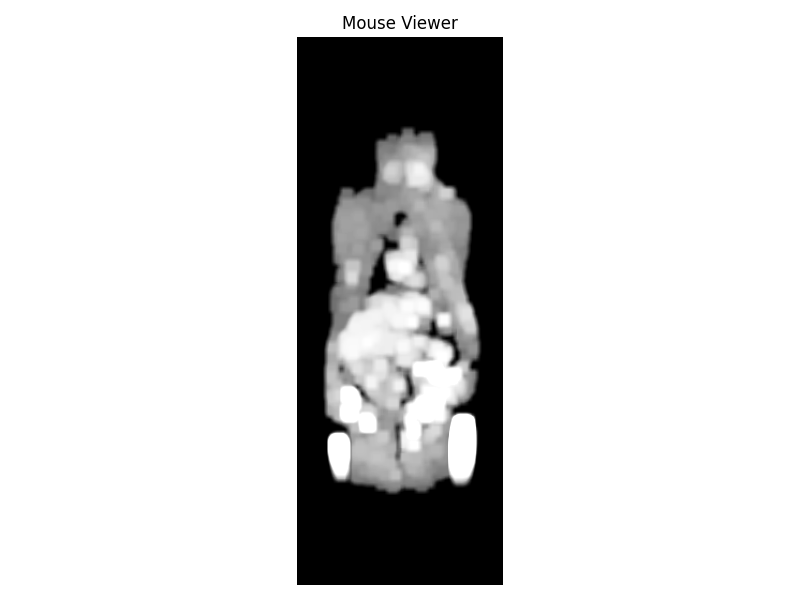

In [28]:
gui.MultiImageDisplay(image_list=[filtered_image], title_list=['Mouse Viewer'], figure_size=(8,6))

In [19]:
#!mkdir binary_images

In [29]:
binary_path = "binary_images/"

for file in os.listdir(filter_path):
    f = os.path.join(filter_path, file)
    # checking if it is a file
    if os.path.isfile(f):
        ds = dcmread(f)
        filtered_image = binarize_image(ds.pixel_array)
        #filtered_image = smooth_edges(filtered_image)
        
        save_dicom_file(ds, filtered_image, os.path.join(binary_path, file))

In [30]:
reader = sitk.ImageSeriesReader()
dicom_names = reader.GetGDCMSeriesFileNames(binary_path)
reader.SetFileNames(dicom_names)
binary_image = reader.Execute()

size = image.GetSize()
size

(192, 512, 120)

<IPython.core.display.Javascript object>


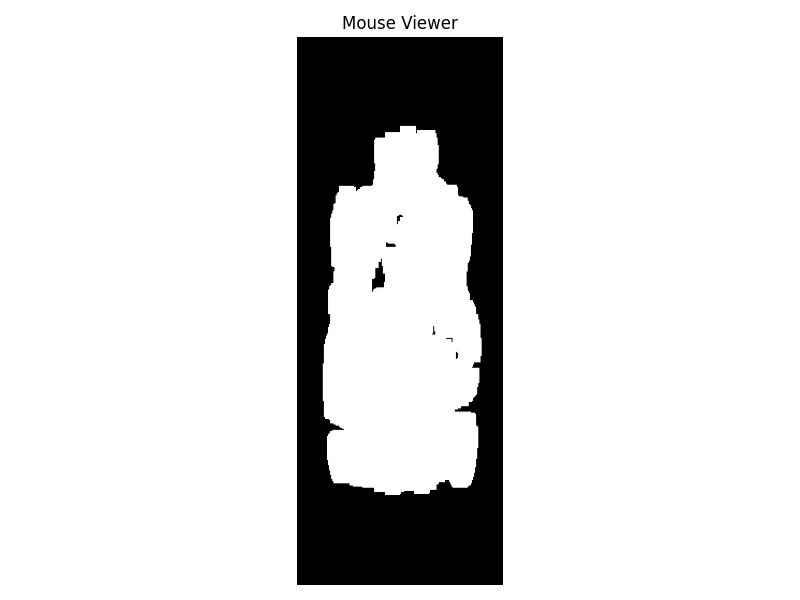

In [31]:
gui.MultiImageDisplay(image_list=[binary_image], title_list=['Mouse Viewer'], figure_size=(8,6))

In [39]:
sitk.WriteImage(binary_image, "mouse.nii.gz")

In [40]:
#Set limits to x and y for a good view
mouse = sitk.ReadImage("mouse.nii.gz")
itkwidgets.view(mouse)

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itk.itkImagePython.itkImageUS3; pr…

In [41]:
!python dicom2stl/dicom2stl.py -i 90 -o mouse.stl mouse.nii.gz


Temp dir: Not specified, will use system temporary directory
Isovalue =  90.0
File names:  ['mouse.nii.gz'] 

Shrink factors:  [1, 2, 1]
(192, 512, 120) -> (192, 256, 120)
     0.01 seconds
Surface extracted
     275408 polygons
     0.14 seconds
Surface cleaned
     275408 polygons
     0.1 seconds
Small parts cleaned
     252516 polygons
     0.2 seconds
Surface smoothed
     252516 polygons
     0.792 seconds
Surface reduced
     25251 polygons
     1.975 seconds
Writing 25251 polygons to mouse.stl
writeSTL 1
Output mesh: mouse.stl



In [42]:
mesh = vtkutils.readMesh('mouse.stl')
itkwidgets.view(mesh, geometries=[mesh])

Input mesh: mouse.stl


Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

In [43]:
!python dicom2stl/dicom2stl.py --help

usage: dicom2stl.py [-h] [--verbose] [--debug] [--output OUTPUT] [--meta META]
                    [--ct] [--clean] [--temp TEMP] [--search SEARCH]
                    [--type {skin,bone,soft_tissue,fat}] [--anisotropic]
                    [--isovalue ISOVALUE] [--double DOUBLE_THRESHOLD]
                    [--largest] [--rotaxis {X,Y,Z}] [--rotangle ROTANGLE]
                    [--smooth SMOOTH] [--reduce REDUCE] [--clean-small SMALL]
                    [--enable {anisotropic,shrink,median,largest,rotation}]
                    [--disable {anisotropic,shrink,median,largest,rotation}]
                    [filenames [filenames ...]]

positional arguments:
  filenames

optional arguments:
  -h, --help            show this help message and exit
  --verbose, -v         Enable verbose messages
  --debug, -D           Enable debugging messages
  --output OUTPUT, -o OUTPUT
                        Output file name (default=result.stl)
  --meta META, -m META  Output metadata file
  --ct    

In [44]:
!python dicom2stl/dicom2stl.py -a -i 90 -t soft_tissue -l --smooth 100 --reduce 0.6 -x 0.1 -o mouse_2.stl mouse.nii.gz


Temp dir: Not specified, will use system temporary directory
Tissue type:  soft_tissue
Isovalue =  90.0
File names:  ['mouse.nii.gz'] 

Shrink factors:  [1, 2, 1]
(192, 512, 120) -> (192, 256, 120)
     0.013000000000000001 seconds
Anisotropic Smoothing
     4.1770000000000005 seconds
Median filter
     -14.054 seconds
Surface extracted
     206862 polygons
     0.17500000000000002 seconds
Surface cleaned
     199598 polygons
     0.19 seconds
Small parts cleaned
     199598 polygons
     0.166 seconds
Surface smoothed
     199598 polygons
     2.666 seconds
Surface reduced
     79838 polygons
     1.349 seconds
Writing 79838 polygons to mouse_2.stl
writeSTL 1
Output mesh: mouse_2.stl



In [45]:
mesh = vtkutils.readMesh('mouse_2.stl')
itkwidgets.view(mesh, geometries=[mesh])

Input mesh: mouse_2.stl


Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…